In [43]:
from __future__ import unicode_literals, print_function, division
from io import open

import glob

import unicodedata
import string

import codecs

import torch
import torch.nn as nn
from torch.autograd import Variable

import random

import time
import math

In [44]:
def findFiles(path): return glob.glob(path)

In [45]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [46]:
# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


In [47]:
# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter,all_letters,n_letters):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

In [48]:
def category_from_output(output,all_categories):
    _, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [49]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair(all_categories, category_lines):
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [50]:
# One-hot vector for category
def categoryTensor(category, all_categories, n_categories):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, all_letters, n_letters):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, all_letters, n_letters):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [51]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample(all_categories, category_lines, n_categories, all_letters, n_letters):
    category, line = randomTrainingPair(all_categories, category_lines)
    category_tensor = Variable(categoryTensor(category, all_categories, n_categories))
    input_line_tensor = Variable(inputTensor(line, all_letters, n_letters))
    target_line_tensor = Variable(targetTensor(line, all_letters, n_letters))
    return category_tensor, input_line_tensor, target_line_tensor

In [52]:
class RNN(nn.Module):
    def __init__(self, n_categories, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [55]:
train_filenames = glob.glob('./part3_train/*.txt')
print(train_filenames)

val_filenames = glob.glob('./part3_val/*.txt')
print (val_filenames)

['./part3_train/1.txt']
['./part3_val/1.txt']


In [33]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [34]:
train_category_lines={}
train_categories=[]
for filename in findFiles('./part3_train/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    train_categories.append(category)
    lines = readLines(filename)
    train_category_lines[category] = lines

train_n_categories = len(train_categories)
print('n_categories =', train_n_categories, train_categories)
print(unicodeToAscii("O'Néàl"))

n_categories = 1 ['1']
O'Neal


In [35]:
val_category_lines={}
val_categories=[]
for filename in findFiles('./part3_val/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    val_categories.append(category)
    lines = readLines(filename)
    val_category_lines[category] = lines

val_n_categories = len(val_categories)
print('n_categories =', val_n_categories, val_categories)
print(unicodeToAscii("O'Néàl"))

n_categories = 1 ['1']
O'Neal


In [36]:
assert train_n_categories==val_n_categories

# Preparing for Training

Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:

In [37]:
# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample(train_categories,train_category_lines,train_n_categories, all_letters,n_letters)
#     print('category =', category, '/ line =', line)

In [38]:
# for i in range(10):
#     category, line, category_tensor, line_tensor = random_training_pair(val_categories,val_category_lines,val_n_categories, all_letters,n_letters)
#     print('category =', category, '/ line =', line)

For the [loss function `nn.NLLLoss`](http://pytorch.org/docs/nn.html#nllloss) RNN is `nn.LogSoftmax`.

Each loop of training will:

* Create input and target tensors
* Create a zeroed initial hidden state
* Read each letter in and
    * Keep hidden state for next letter
* Compare final output to target
* Back-propagate
* Return the output and loss

In [80]:
def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
#     print (input_line_tensor.size())
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]

In [88]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [41]:
n_hidden = 128
rnn = RNN(train_n_categories, n_letters, n_hidden, n_letters)
hidden = rnn.initHidden()
criterion = nn.NLLLoss()
learning_rate = 1e-4 # If you set this too high, it might explode. If too low, it might not learn
# optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [69]:
n_epochs = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
total_loss = 0
all_losses = []

In [89]:
start = time.time()

for iter in range(1, n_iters + 1):
    category_tensor, input_line_tensor, target_line_tensor=randomTrainingExample(train_categories, train_category_lines, train_n_categories, all_letters, n_letters)
#     print (input_line_tensor.size())
    if input_line_tensor.size()==torch.Size([]):
        iter-=1
        continue
    output, loss = train(rnn, category_tensor, input_line_tensor, target_line_tensor)
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 38s (5000 5%) 2.9277
1m 55s (15000 15%) 2.5411
3m 13s (25000 25%) 2.6404
4m 32s (35000 35%) 1.4807
5m 12s (40000 40%) 2.2875
5m 50s (45000 45%) 1.3821
6m 31s (50000 50%) 3.2902
7m 10s (55000 55%) 2.1980
7m 49s (60000 60%) 1.1697
8m 29s (65000 65%) 1.2485
9m 9s (70000 70%) 0.9972
9m 48s (75000 75%) 2.3093
10m 27s (80000 80%) 2.5993
11m 7s (85000 85%) 0.8607
12m 24s (95000 95%) 0.8020
13m 3s (100000 100%) 0.7389


# Plotting the Results

Plotting the historical loss from `all_losses` shows the network learning:

In [90]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

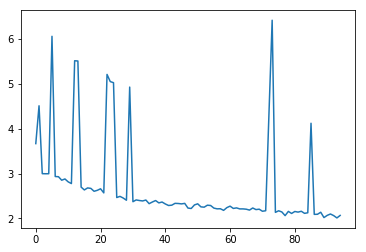

In [91]:
plt.figure()
plt.plot(all_losses)

# Evaluating the Results

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with `evaluate()`, which is the same as `train()` minus the backprop.

In [ ]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(val_n_categories, val_n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(rnn,line_tensor):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category_tensor, input_line_tensor, target_line_tensor=randomTrainingExample(val_categories, val_category_lines, val_n_categories, all_letters, n_letters)
    output = evaluate(rnn,line_tensor)
    guess, guess_i = category_from_output(output, val_categories)
    category_i = val_categories.index(category)
    confusion[category_i][guess_i] += 1

In [ ]:
# Normalize by dividing every row by its sum
for i in range(val_n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + val_categories, rotation=90)
ax.set_yticklabels([''] + val_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

# Running on User Input

In [ ]:
def predict(input_line, n_predictions=1):
    print('\n> %s' % input_line)
    output = evaluate(rnn,Variable(line_to_tensor(input_line,all_letters,n_letters)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, val_categories[category_index]))
        predictions.append([value, val_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

The final versions of the scripts [in the Practical PyTorch repo](https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification) split the above code into a few files:

* `data.py` (loads files)
* `model.py` (defines the RNN)
* `train.py` (runs training)
* `predict.py` (runs `predict()` with command line arguments)
* `server.py` (serve prediction as a JSON API with bottle.py)

Run `train.py` to train and save the network.

Run `predict.py` with a name to view predictions: 

```
$ python predict.py Hazaki
(-0.42) Japanese
(-1.39) Polish
(-3.51) Czech
```

Run `server.py` and visit http://localhost:5533/Yourname to get JSON output of predictions.

# Exercises

* Try with a different dataset of line -> category, for example:
    * Any word -> language
    * First name -> gender
    * Character name -> writer
    * Page title -> blog or subreddit
* Get better results with a bigger and/or better shaped network
    * Add more linear layers
    * Try the `nn.LSTM` and `nn.GRU` layers
    * Combine multiple of these RNNs as a higher level network

**Next**: [Generating Shakespeare with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)